Loading data...
Merging data...
0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
      ..
76   NaN
77   NaN
78   NaN
79   NaN
80   NaN
Name: rolling_avg_tickets, Length: 81, dtype: float64
Training XGBoost model...
RMSE: 2525.74
MAE: 1946.14
Predicting 2024 ticket sales...
2024 ticket sales predictions saved!


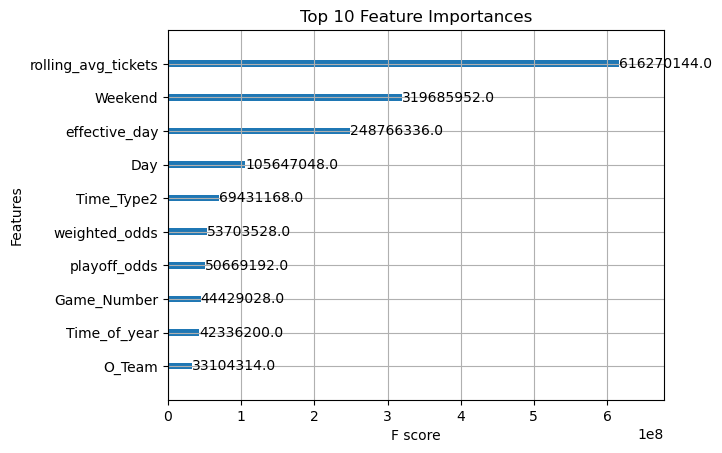

In [11]:
import pandas as pd 
import numpy as np 
import os 
from xgboost import XGBRegressor 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error, mean_absolute_error 
import matplotlib.pyplot as plt 
import seaborn as sns 

# Set file path
base_path = "C:/Users/efeco/OneDrive/Masaüstü/Emory MSBA/Spring - Sports Analytics/Braves - Demand Forecasting Assignment/"


ticketing_files = {
    "2018": os.path.join(base_path, "2018_Ticketing_Data.csv"),
    "2019": os.path.join(base_path, "2019_Ticketing_Data.csv"),
    "2021": os.path.join(base_path, "2021_Ticketing_Data.csv"),
    "2022": os.path.join(base_path, "2022_Ticketing_Data.csv"),
    "2023": os.path.join(base_path, "2023_Ticketing_Data.csv"),
    "2024": os.path.join(base_path, "2024_Ticketing_Data.csv")
}

schedule_files = {
    "2018": os.path.join(base_path, "2018_Schedule_info.csv"),
    "2019": os.path.join(base_path, "2019_Schedule_info.csv"),
    "2021": os.path.join(base_path, "2021_Schedule_info.csv"),
    "2022": os.path.join(base_path, "2022_Schedule_info.csv"),
    "2023": os.path.join(base_path, "2023_Schedule_info.csv"),
    "2024": os.path.join(base_path, "2024_Schedule_info.csv")
}

# Load data
print("Loading data...")
ticketing_data = {}
schedule_data = {}

for year, file in ticketing_files.items():
    if os.path.exists(file):
        ticketing_data[year] = pd.read_csv(file)
    else:
        print(f"File not found: {file}")

for year, file in schedule_files.items():
    if os.path.exists(file):
        schedule_data[year] = pd.read_csv(file)
    else:
        print(f"File not found: {file}")

# Convert date format for consistency
for year in ticketing_data.keys():
    ticketing_data[year]['Date'] = pd.to_datetime(ticketing_data[year]['Date'], errors='coerce')

for year in schedule_data.keys():
    schedule_data[year]['Date'] = pd.to_datetime(schedule_data[year]['Date'], errors='coerce')

# Merge ticketing and schedule data
print("Merging data...")
merged_data = {}
for year in ticketing_data.keys():
    if year in schedule_data:
        merged_data[year] = pd.merge(ticketing_data[year], schedule_data[year], on="Date", how="left")

# Encode categorical variables
from sklearn.preprocessing import LabelEncoder
categorical_features = ['O_Team', 'Day', 'Time_of_year', 'Month', 'effective_day']
label_encoders = {feature: LabelEncoder() for feature in categorical_features}

for year, df in merged_data.items():
    for feature in categorical_features:
        df[feature] = label_encoders[feature].fit_transform(df[feature].astype(str))

# Fill missing values in 'weighted_odds' for 2024
for year in merged_data.keys():
    if 'weighted_odds' in merged_data[year].columns:
        past_years = [y for y in merged_data.keys() if y != "2024"]
        mean_weighted_odds = pd.concat([merged_data[y]['weighted_odds'] for y in past_years if 'weighted_odds' in merged_data[y].columns]).mean()
        merged_data[year].loc[:, 'weighted_odds'] = merged_data[year]['weighted_odds'].fillna(mean_weighted_odds)

# Create rolling average for ticket sales (except for 2024)
for year in merged_data.keys():
    if "Tickets" in merged_data[year].columns:
        merged_data[year]['rolling_avg_tickets'] = merged_data[year]['Tickets'].rolling(window=3, min_periods=1).mean()

# Ensure rolling_avg_tickets is present in 2024 dataset
if 'rolling_avg_tickets' not in merged_data["2024"].columns:
    merged_data["2024"]['rolling_avg_tickets'] = merged_data["2024"].get('Tickets', pd.Series()).rolling(window=3, min_periods=1).mean()

print(merged_data["2024"].rolling_avg_tickets)

# Prepare training and validation datasets
train_years = ["2018", "2019", "2021", "2022"]
valid_year = "2023"

train_data = pd.concat([merged_data[year] for year in train_years], axis=0)
valid_data = merged_data[valid_year]

features = ['Game_Number', 'Time_of_year', 'Day', 'effective_day', 'O_Team', 'Time_Type2',
            'Month', 'Weekend', 'playoff_odds', 'first_homestand', 'weighted_odds', 'rolling_avg_tickets']
target = 'Tickets'

train_data = train_data.dropna(subset=features + [target])
valid_data = valid_data.dropna(subset=features + [target])

X_train, y_train = train_data[features], train_data[target]
X_valid, y_valid = valid_data[features], valid_data[target]

# Train XGBoost model
print("Training XGBoost model...")
xgb_model = XGBRegressor(n_estimators=50, learning_rate=0.1, max_depth=3, random_state=42)
xgb_model.fit(X_train, y_train)

# Predict on 2023 validation data
y_pred = xgb_model.predict(X_valid)

# Evaluate model
rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
mae = mean_absolute_error(y_valid, y_pred)
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

# Predict ticket sales for 2024
print("Predicting 2024 ticket sales...")
X_2024 = merged_data["2024"][features]
predictions_2024 = xgb_model.predict(X_2024)

predicted_2024_tickets = merged_data["2024"][["event_name", "Date"]].copy() 
predicted_2024_tickets["tickets"] = predictions_2024 

# Save predictions
predicted_2024_tickets.to_csv("2024_ticket_sales_predictions.csv", index=False) 
print("2024 ticket sales predictions saved!") 

import matplotlib.pyplot as plt
from xgboost import plot_importance

# Plot feature importance
plot_importance(xgb_model, importance_type='gain', max_num_features=10)
plt.title('Top 10 Feature Importances')
plt.show()

